In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import os,datetime

from PIL import Image

from vgg import vgg_structure,file_vgg_read
from sklearn.cluster import KMeans

## Image Processing

In [2]:
class Image_Preprocess(object):
    '''Class for pre-processing content & style images and initialize target image.
    
    Attributes:
        content_image : (H,W,C) np.float32 array
        style_image : (H,W,C) np.float32 array
        
        target_mask_image : (H,W,C) np.float32 array
        style_mask_image : (H,W,C) np.float32 array
        target_masks_origin: (n_masks,H,W) np.float32 array
        style_masks_origin: (n_masks,H,W) np.float32 array
        
    '''
    
    def __init__(self, content_path, style_path, \
                 target_width, target_height, \
                 #Parameters only related to guided style transfer
                 Kmeans_or_NOT = False, \
                 content_mask_path = None, \
                 style_mask_path = None, \
                 mask_n_colors = None, \
                ):
        """
        Args:
            content_path (str) : file path to content image
            style_path (str)   : file path to style image
            target_width (int) : desired width of target image
            target_height (int): desited height of target image
            noise_ratio (float): in range [0,1], percentage of uniform noise to mix into 
                                    target image initialization.

        """
        content_tensor = self.get_image(content_path)
        style_tensor = self.get_image(style_path)
        self.content_image = self.resized_image(content_tensor, target_width, target_height)
        self.style_image = self.resized_image(style_tensor, target_width, target_height)
        # deduct by the color intensity of each pixel by the mean-center given by vgg
        self.content_image -= np.array([[[123.68 , 116.779, 103.939]]],dtype=np.float32)
        self.style_image -= np.array([[[123.68 , 116.779, 103.939]]],dtype=np.float32)
        
        if Kmeans_or_NOT:
            # read masks
            content_mask_tensor = self.get_image(content_mask_path)
            style_mask_tensor = self.get_image(style_mask_path)
            content_mask = self.resized_image(content_mask_tensor, \
                                                target_width, target_height)
            style_mask = self.resized_image(style_mask_tensor, \
                                              target_width, target_height)
            # deduct by the color intensity of each pixel by the mean-center given by vgg
            self.target_mask_image = content_mask - np.array([[[123.68 , 116.779, 103.939]]],dtype=np.float32)
            self.style_mask_image =  style_mask -np.array([[[123.68 , 116.779, 103.939]]],dtype=np.float32)
            
            # turn into nparray of shape (H*W,3)
            content_mask_resize = content_mask.reshape(content_mask.shape[0]*content_mask.shape[1], -1)
            style_mask_resize = style_mask.reshape(style_mask.shape[0]*style_mask.shape[1], -1)
            
            # K-means for style image and target image
            kmeans = KMeans(n_clusters=mask_n_colors, random_state=0).fit(style_mask_resize)
            
            target_labels = kmeans.predict(content_mask_resize.astype(np.float32))
            target_labels = target_labels.reshape([content_mask.shape[0], content_mask.shape[1]])
            style_labels = kmeans.predict(style_mask_resize.astype(np.float32))
            style_labels = style_labels.reshape([style_mask.shape[0], style_mask.shape[1]])
            #print(style_labels.shape)
            target_masks = []
            style_masks = []
            
            for i in range(mask_n_colors):
                target_masks.append((target_labels == i).astype(np.float32))
                style_masks.append((style_labels == i).astype(np.float32))
                
            self.target_masks_origin = np.stack(target_masks)
            self.style_masks_origin = np.stack(style_masks)
            
            #print(self.target_masks_origin.shape,self.target_masks_origin.dtype)
            #print(self.style_masks_origin.shape,self.style_masks_origin.dtype)

        
    def get_image(self, image_path):
        '''get image TF tensor.
        
        Returns:
            dtype = (H_origial,W_original,C) tf.float32 tensor
            
        '''
        image_raw = tf.read_file(image_path)
        image_tensor = tf.image.decode_image(image_raw)
        return image_tensor
    
    def resized_image(self, image_tensor, target_width, target_height):
        '''get the resized image nparray.
        
        Returns:
            dtype= (H,W,C) np.float32 array
            
        '''
        #TODO: TENSORFLOW HAS VAGUE RESHAPE BAHAVIOR, change to PIL and CROP?
        with tf.Session() as sess:
            image = sess.run(image_tensor)
            resized_image = sess.run(tf.image.resize_images(image, (target_width, target_height)))
        return resized_image
    

    def initialize_sythetic_image(self, noise_ratio):
        '''Random uniform initialization mixed with content
        
        Returns:
            dtype= (1,H,W,C) np.float32 array. Note the dimension padding.
            
        '''
        noise_image = np.random.uniform(low=0,high= 256,size= self.content_image.shape).astype(np.float32)
        noise_image -= np.array([[[123.68 , 116.779, 103.939]]],dtype=np.float32)
        
        return np.expand_dims(noise_image * noise_ratio + self.content_image * (1 - noise_ratio),axis=0)


def save(path, image_unnormalized_nparray):
    '''add back VGG-19 pixel avgs to a processed image represented by a 
    (H,W,C) np.float32 array and save it to path'''
    
    print('adding back pixel averages and saving image to',path)
    image = image_unnormalized_nparray + np.array([[[123.68 , 116.779, 103.939]]],dtype=np.float32)
    print('RGB avg of this image:',np.mean(image,axis=(0,1)))
    #print(image.dtype)
    #avoid overflow of colors, valid range [0,255] inclusive
    image[image>255] = 255
    image[image<0] = 0
    im = Image.fromarray(np.rint(image).astype(np.uint8))
    im.save(path)

def make_dir(path):
    '''create the dir to save data'''
    if os.path.isdir(path):  
        print('dir '+path+' exists, no need to create it.')
        pass
    else:
        print('dir '+path+' did not exist, now created')
        os.mkdir(path)  

## Loss Functions, without Kmeans

In [3]:
# compute the content_loss
def content_loss(content_image_l, process_image_l):
    '''Content loss for one layer
    Args:
        c_tensor: (B,H,W,C) tf.float32 tensor from style image
        p_tensor: (B,H,W,C) tf.float32 tensor from target image
        
    Returns:
        tf.float32 scalar, content loss in one layer
    
    '''
    
    diff = content_image_l - process_image_l;
    denominator = tf.cast(tf.size(content_image_l), tf.float32)
    
    return tf.nn.l2_loss(diff)/denominator

In [4]:
# compute the style loss
def style_loss(s_tensor, p_tensor):
    '''Style loss for one layer.
    
    Args:
        s_tensor: (B,H,W,C) tf.float32 tensor from style image
        p_tensor: (B,H,W,C) tf.float32 tensor from target image
        
    Returns:
        tf.float32 scalar, style loss in one layer
        
    '''
    
    shape_list = tf.shape(s_tensor) #get shape as a list of 4 tf.int32 numbers
    
    M = shape_list[1] * shape_list[2]; N = shape_list[3]
    denominator = tf.cast(2*M*N*N,dtype=tf.float32)
    
    s_tensor_2d = tf.reshape(s_tensor[0], (M, N))
    s_gram = tf.matmul(tf.transpose(s_tensor_2d), s_tensor_2d)

    p_tensor_2d = tf.reshape(p_tensor[0], (M, N))
    p_gram = tf.matmul(tf.transpose(p_tensor_2d), p_tensor_2d)
    
    diff = (s_gram-p_gram)/denominator
    #denominator = tf.cast(tf.size(content_image_l), tf.float32)

    return tf.nn.l2_loss(diff)

In [5]:
def variation_loss(p_tensor):
    '''Variational loss for smoothing
    
    Args:
        p_tensor: (B,H,W,C) tf.float32 tensor from target image
        
    Returns:
        tf.float32 scalar, variational loss of image tensor
    
    '''
    shape_list = tf.shape(p_tensor) #get shape as a list of 4 tf.int32 numbers
    
    H = shape_list[1]; W = shape_list[2]; C = shape_list[3]
    #difference between adjacent pixels along height, normalized
    diff1 = (p_tensor[:,1:,:,:] - p_tensor[:,:H-1,:,:])/tf.cast(H*C,tf.float32)
    #difference between adjacent pixels along width, normalized
    diff2 = (p_tensor[:,:,1:,:] - p_tensor[:,:,:W-1,:])/tf.cast(W*C,tf.float32)
    
    #use l2 norm
    return tf.reduce_sum(tf.abs(diff1)) + tf.reduce_sum(tf.abs(diff2))
    

In [6]:
def sum_loss(content_vgg,style_vgg,
             layer_list_content, layer_list_style, image_group, 
             process_image,w_c,w_s, 
             content_weight, style_weight, variation_weight):
    '''Compute total loss.
    
    Args:
        process_image:  (B,H,W,C) tf.float32 tensor that we want to optimize over
    
    Returns:
        total loss = content_weight*(sum(w_c*content_loss))+style_weight*(sum(w_s*style_loss))
    
    '''
    process_vgg = vgg_structure()
    process_vgg.build(process_image,layers_info)

    # calculating content loss for output of layers in layer_list_content
    contentloss = 0
    i = 0
    for layer_name in layer_list_content:
        output_content = getattr(content_vgg, layer_name) 
        output_process = getattr(process_vgg, layer_name) 
        contentloss += w_c[i] * content_loss(output_content,output_process)
        i += 1
    #contentloss /= float(sum(w_c))
    
    # calculating content loss for output of layers in layer_list_style    
    styleloss = 0
    i = 0
    for layer_name in layer_list_style:
        output_style   = getattr(style_vgg,   layer_name) 
        output_process = getattr(process_vgg, layer_name) 
        styleloss += w_s[i]*style_loss(output_style, output_process)
        i += 1
    #styleloss /= float(sum(w_s))
    
    varloss = variation_loss(process_image)
    
    return content_weight * contentloss + style_weight * styleloss + variation_weight*varloss


## Loss functions, with Kmeans

In [7]:
# Compute the loss based on K-means
# Special cases for with k means
def masked_gram(x, mx, mask_norm, N):
    """
    x = style_features or target_net
    mx = style_masks or target_masks
    mask_norm = mask normalization type
    
    """
    R, a, b = mx.shape # [numberOfMasks, h, w]
    M = a * b

    # TODO: use local variable?
    mx = tf.reshape(mx, [R, M])
    x = tf.reshape(x, [M, N])
    x = tf.transpose(x) # N * M
    masked_gram = []
    for i in range(R):
        mask = mx[i]
        #print(mask.shape)
        masked_x = x * mask
        if mask_norm == 'square_sum':
            K = 1. / tf.cast(tf.math.reduce_sum(tf.math.square(mask)), tf.float32)
        elif mask_norm == 'sum':
            K = 1. / tf.cast(tf.math.reduce_sum(mask), tf.float32)
        gram = K * tf.matmul(masked_x, tf.transpose(masked_x))
        masked_gram.append(gram)
    return tf.stack(masked_gram)

#if k means
def masked_style_layer_loss(a, ma, x, mx, mask_norm):
    ma = tf.transpose(ma[0], perm=[2,0,1]) # [numberOfMasks, h, w]
    mx = tf.transpose(mx[0], perm=[2,0,1]) # [numberOfMasks, h, w]
    _, _, _, N = a.get_shape()
    R, _, _ = ma.shape
    #K = 1. / tf.cast(4 * N * N * R, tf.float32)
    A = masked_gram(a, ma, mask_norm, N)
    G = masked_gram(x, mx, mask_norm, N)
    
    denominator = tf.cast(R*N*N,dtype=tf.float32)
    diff = (A-G)/denominator
    
    #loss = K * tf.reduce_sum( tf.pow((G - A), 2) )
    return tf.nn.l2_loss(diff)

In [8]:
# compute the sum loss   
def sum_loss_with_mask(content_vgg,style_vgg,style_mask_vgg, target_mask_vgg, mask_norm,
                       layer_list_content, layer_list_style, 
                       image_group, target_image,
                       w_c,w_s,
                       content_weight, style_weight, variation_weight):
    '''Compute total loss when using Kmeans.
    
    Args:
        process_image:  (B,H,W,C) tf.float32 tensor that we want to optimize over
    
    Returns:
        total loss = content_weight*(sum(w_c*content_loss))+style_weight*(sum(w_s*style_loss))
    
    '''
    
    target_vgg = vgg_structure()
    target_vgg.build(target_image,layers_info)

    # calculating content loss for output of layers in layer_list_content
    contentloss = 0
    i = 0
    for layer_name in layer_list_content:
        output_content = getattr(content_vgg, layer_name) 
        output_process = getattr(target_vgg, layer_name) 
        contentloss += w_c[i] * content_loss(output_content,output_process)
        i += 1
    #contentloss /= float(sum(w_c))
    
    # calculating content loss for output of layers in layer_list_style    
    styleloss = 0
    i = 0
    for layer_name in layer_list_style:
        output_style   = getattr(style_vgg,   layer_name)
        m_output_style = getattr(style_mask_vgg,   layer_name)
        output_target  = getattr(target_vgg, layer_name) 
        m_output_target = getattr(target_mask_vgg, layer_name) 
        styleloss += w_s[i] * masked_style_layer_loss(output_style, m_output_style ,
                                                      output_target, m_output_target,
                                                      mask_norm)
        i += 1
    #styleloss /= float(sum(w_s))
    
    varloss = variation_loss(target_image)
    
    return content_weight * contentloss + style_weight * styleloss + variation_weight*varloss

In [9]:
'''with tf. Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print(sess.run(sum_loss_with_mask(content_vgg,style_vgg,style_mask_vgg, target_mask_vgg, mask_normalization_type,
                       layer_list_content, layer_list_style, 
                       image_group, process_image,
                       w_c,w_s,
                       content_weight, style_weight, variation_weight)))'''

'with tf. Session() as sess:\n    sess.run(tf.global_variables_initializer())\n    \n    print(sess.run(sum_loss_with_mask(content_vgg,style_vgg,style_mask_vgg, target_mask_vgg, mask_normalization_type,\n                       layer_list_content, layer_list_style, \n                       image_group, process_image,\n                       w_c,w_s,\n                       content_weight, style_weight, variation_weight)))'

## Train

### Adjustable Parameters

In [10]:
'''Image settings.'''
#save to a directory with today's date and run label
output_dir_prefix = datetime.date.today().strftime('%m-%d-%Y') + "_cat_restaurant_0"

content_path = "image_with_mask/1000x800cat.jpg"
#style_path = "image_with_mask/1880x1500-restaurant.jpg"
style_path = "image_with_mask/1045x805-the-schelde-at-veere.jpg"
target_width = 400
target_height = 500
layers_info = file_vgg_read("imagenet-vgg-verydeep-19.mat")

# CNN layers info
content_weight = 1e-2 # content weights for total content loss alpha kinda redundant
style_weight = 1 # style weights for total style loss beta 
variation_weight= 1e-5 #variational weight for smoothing
w_c = np.array([1],dtype=np.float32) # content weights for each layer
w_s = np.array([1, 1, 1, 1, 1],dtype=np.float32) # style weights for each layer

layer_list_content = ["conv4_2"]
layer_list_style = ["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"]


'''Optimization settings'''
#How many iters of optimization?
epoches = 401
#Learning rate depends on optimizer choice
lr = 10
noise_ratio = 0.5 # initial noise #MIX content with uniform noise,noise_ratio*noise+(1-noise_ratio) * content

# Record Image every 5 steps in the beginning of training, because it changes faster
# in the initial phase than later.
record_steps_early = 5
record_steps_late = 20

# Hyperparameters tuning
lr_decay_or_NOT = True # True or False (Learning Rate Decay)
optimizer_choice = "adam" #"adam", "gradient_descent", ####### NOT IMPLEMENTED"momentum"

'''Guided Style trasfer settings'''
Kmeans_or_NOT = False
content_mask_path = "image_with_mask/content_mask_6(2).png"
style_mask_path = "image_with_mask/style_mask_6.png"
mask_n_colors = 2 # nbr of clusters for K-means
mask_normalization_type = 'square_sum' #sum or square sum two options
mask_downsample_type = 'simple' #what's options??

## Variables set up for training

In [11]:
# reset the tensorflow default graph
tf.reset_default_graph()

#global step (current training step, initialized as 0)
global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name="global_step")
# global variables: preprocessed image_group
image_group = Image_Preprocess(content_path = content_path, style_path = style_path, \
                               target_width = target_width, target_height = target_height, \
                               #parameters related to Kmeans only
                               Kmeans_or_NOT = Kmeans_or_NOT, \
                               content_mask_path = content_mask_path, \
                               style_mask_path = style_mask_path, \
                               mask_n_colors = mask_n_colors)

# global variable: this is what we want to optimize!
process_image = tf.Variable(image_group.initialize_sythetic_image(noise_ratio), \
                            dtype=tf.float32, trainable = True, name = "process_image")

# save source images before training occurs
make_dir(output_dir_prefix)
save(output_dir_prefix+'/reshaped_content.jpg',image_group.content_image)
save(output_dir_prefix+'/reshaped_style.jpg',image_group.style_image)
if Kmeans_or_NOT:
    save(output_dir_prefix+'/reshaped_content_mask.jpg',image_group.target_mask_image)
    save(output_dir_prefix+'/reshaped_style_mask.jpg',image_group.style_mask_image)

# let content and style images go through the vgg net
content_image = np.expand_dims(image_group.content_image.copy(),axis=0)
style_image = np.expand_dims(image_group.style_image.copy(),axis=0)
content_vgg = vgg_structure()
content_vgg.build(content_image,layers_info)
style_vgg = vgg_structure()
style_vgg.build(style_image,layers_info)
# extra stuff if Kmeans is applied
if Kmeans_or_NOT:
    target_masks_origin = image_group.target_masks_origin.copy()
    target_masks_origin = target_masks_origin.transpose([1,2,0]) # [numberOfMasks, h, w] -> [h, w, masks]
    target_masks_origin = target_masks_origin[np.newaxis, :]
    
    style_masks_origin = image_group.style_masks_origin.copy()
    style_masks_origin = style_masks_origin.transpose([1,2,0]) # [numberOfMasks, h, w] -> [h, w, masks]
    style_masks_origin = style_masks_origin[np.newaxis, :] 
    
    target_mask_vgg = vgg_structure()
    target_mask_vgg.buildmask(target_masks_origin, mask_downsample_type)

    style_mask_vgg = vgg_structure()
    style_mask_vgg.buildmask(style_masks_origin, mask_downsample_type)
    

Instructions for updating:
Colocations handled automatically by placer.
dir 06-11-2019_cat_restaurant_0 did not exist, now created
adding back pixel averages and saving image to 06-11-2019_cat_restaurant_0/reshaped_content.jpg
RGB avg of this image: [122.6038  110.74236  94.96799]
adding back pixel averages and saving image to 06-11-2019_cat_restaurant_0/reshaped_style.jpg
RGB avg of this image: [158.81564 143.37299  98.30551]


In [12]:
# parameters to record loss
#
loss_plot ={}

def train(max_step = epoches, 
          record_steps_early = record_steps_early, 
          record_steps_late = record_steps_late,
          learning_rate = lr, 
          lr_decay_or_NOT = lr_decay_or_NOT,
          #layer_list_content = layer_list_content, 
          #layer_list_style = layer_list_style, 
          #w_c = w_c , w_s = w_s,
          Kmeans_or_NOT = Kmeans_or_NOT,
          optimizer_choice = optimizer_choice
         ):
    '''Minimize total loss function to obtain best syntheized image.
    Args:
        max_steps (int):          number of training epochs/iterations
        record_steps_early(int):  interval for saving image in beginning of optimization
        record_steps_late(int):   interval for saving image in end of optimization
        learning_rate(float):     [initial] learning rate for optimizer
        lr_decay_or_NOT(bool):    whether to use learning rate decay
        Kmeans_or_NOT(bool):      whether to use Guided style transfer
        optimizer_choice(string): 'adam' or 'gradient_descent'
    '''
    
    if Kmeans_or_NOT:
        print("Using masked loss...")
        #loss = sum_loss_with_mask(layer_list_content, layer_list_style,
        #                          image_group, process_image,w_c, w_s,
        #                          mask_normalization_type,content_weight,style_weight)
        loss = sum_loss_with_mask(content_vgg,style_vgg,
                                  style_mask_vgg, target_mask_vgg, mask_normalization_type,
                                  layer_list_content, layer_list_style,
                                  image_group, process_image,
                                  w_c,w_s,
                                  content_weight, style_weight, variation_weight)
    else:
        print("Using original loss...")    
        loss = sum_loss(content_vgg,style_vgg,
                        layer_list_content, layer_list_style, \
                        image_group, process_image, 
                        w_c, w_s,content_weight,style_weight,variation_weight)
        
    if lr_decay_or_NOT:
        print("Using learning rate decay...")
        starter_learning_rate = learning_rate
        end_learning_rate = learning_rate/10
        decay_steps = 500
        learning_rate = tf.train.polynomial_decay(starter_learning_rate, global_step,
                                          decay_steps, end_learning_rate,
                                          power=1)
        
    # Optimizer
    if optimizer_choice == "gradient_descent":
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        print("Using GradientDescentOptimizer...")
    elif optimizer_choice == "adam":
        optimizer = tf.train.AdamOptimizer(learning_rate)
        print("Using AdamOptimizer...")
    ##elif optimizer_choice == "momentum":
    #    optimizer = tf.train.MomentumOptimizer(learning_rate)
    #    print("Using MomentumOptimizer...")
    else:
        raise ValueError("Invalid optimizer.")
    
    train_step = optimizer.minimize(loss, global_step = global_step,var_list = [process_image])

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        initial_step = global_step.eval()
        print("training begin!")
        
        for step in np.arange(initial_step, max_step):
            #print('step',step)
            
            sess.run(train_step)
            
            if (step <= max_step//4 and step % record_steps_early == 0) or \
               (step > max_step//4 and step % record_steps_late == 0):
                
                if Kmeans_or_NOT:
                    loss_val = sess.run(loss)
                else:
                    loss_val = sess.run(loss)
                
                loss_plot[step+1] = loss_val
                print(" \n Step {}  Total loss: {:5.1f}".format(step + 1, loss_val))
                
                result_image = sess.run(process_image)[0]
                print("\n Step {}   Sum of all pixels: {:5.1f}".format(step + 1, np.sum(result_image)))
                
                # save the image during the training process
                filename = output_dir_prefix+"/step_%d.png" % step
                save(filename, result_image)

## Go

In [13]:
train()

Using original loss...
Using learning rate decay...
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Using AdamOptimizer...
training begin!
 
 Step 1  Total loss: 1338.8

 Step 1   Sum of all pixels: 2372089.0
adding back pixel averages and saving image to 06-11-2019_cat_restaurant_0/step_0.png
RGB avg of this image: [125.66308 120.03325 110.56328]
 
 Step 6  Total loss: 650.8

 Step 6   Sum of all pixels: 2047100.4
adding back pixel averages and saving image to 06-11-2019_cat_restaurant_0/step_5.png
RGB avg of this image: [129.54169 123.49515 101.59804]
 
 Step 11  Total loss: 434.4

 Step 11   Sum of all pixels: 1737104.9
adding back pixel averages and saving image to 06-11-2019_cat_restaurant_0/step_10.png
RGB avg of this image: [134.67142 125.84694  92.56539]
 
 Step 16  Total loss: 333.9

 Step 16   Sum of all pixels: 1691804.4
adding back pixel averages and saving image to 06-11-2019_cat_restaurant_0/step_15.png
RGB avg of this image: [139.7409  127.0

### Plot total loss vs. iterations

In [16]:
# save total loss
np.savetxt(output_dir_prefix+"/total_loss.dat", [list(loss_plot.keys()), list(loss_plot.values())], delimiter=',') 

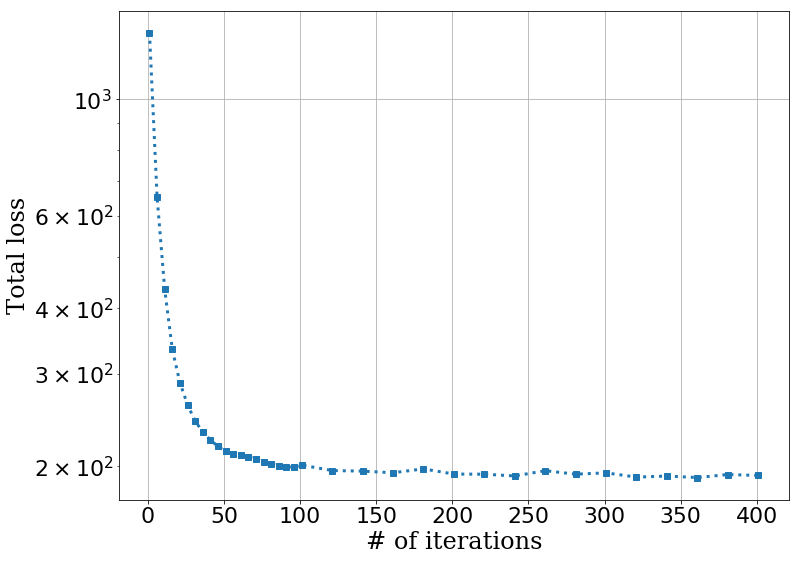

In [17]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 24,}

plt.rc('xtick',labelsize=22)
plt.rc('ytick',labelsize=22)
plt.rcParams["figure.figsize"] = (12,9)
plt.xlabel("# of iterations",fontdict=font)
plt.ylabel("Total loss",fontdict=font)
plt.plot(list(loss_plot.keys()), loss_plot.values(),'s:',linewidth =3)
plt.yscale('log')

plt.grid()
plt.savefig(output_dir_prefix+'/loss_vs_iter.png',dpi=300)

References:
1. https://github.com/NELSONZHAO/zhihu/tree/master/image_style_transfer?1529570173001&fbclid=IwAR3mjQzn6yGLKmdJ5aU8h0L4SqtQuP12YIAExTnlIfHsj9PGuU-ssYPhcvs
2. https://github.com/wzirui/guided-neural-style